In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

# Download file from https://drive.google.com/file/d/10aZF97UPMUChScEQ0jGug9gs5M8pdzxA/view?usp=drive_link and save in the same directory as this notebook

df = pd.read_csv('profiles.csv')

In [2]:
pd.set_option('display.max_columns', None)

# Exploring the Data

## Continuous Variables

### age

The next plot shows the distribution of age in the group. It seems that most users are in their late 20s to early 30s.

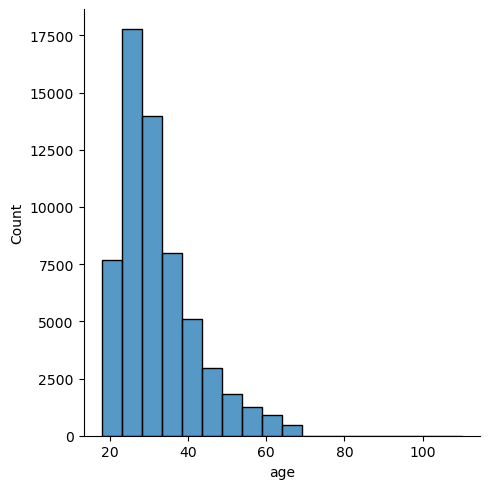

In [3]:
sns.displot(data=df, x="age", kind="hist", binwidth = 5)

Here is the same chart but broken down by gender. It seems that there are proportionally similar break down of gender by age, but slightly fewer females overall.

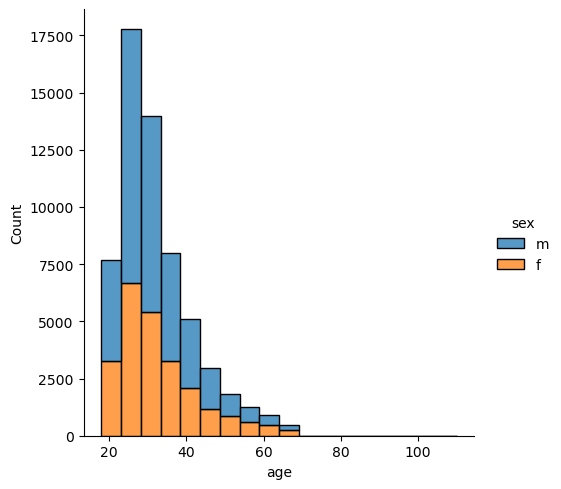

In [4]:
sns.displot(data=df, x="age", hue="sex", kind="hist", binwidth = 5, multiple = "stack")

### Income

Here is the data of income, it seems that the majority of the participants do not include their income figures.

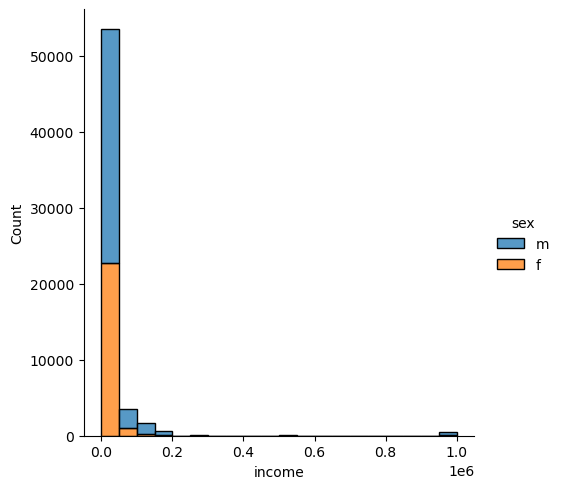

In [5]:
sns.displot(data=df, x="income",hue="sex", kind="hist", binwidth = 50000, multiple = "stack")

## Discrete Variables

### Sex

Previously it was identified that there are more males in the data, and it seems that there are ~35,000 men to ~25,000 women.

<Axes: xlabel='count', ylabel='sex'>

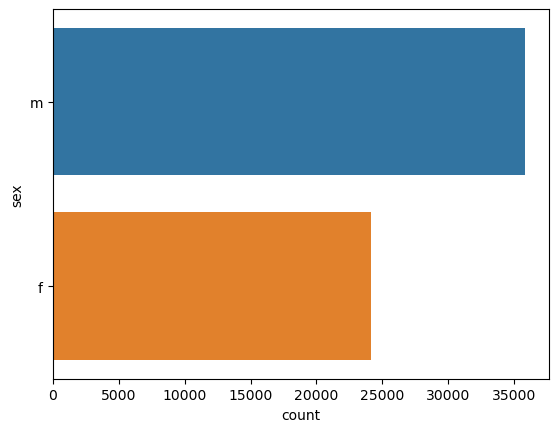

In [6]:
sns.countplot(data=df, y="sex", hue="sex")

### Drinks

The next plot shows that the majority of the users drink "socially", then "rarely" and "often". 

<Axes: xlabel='count', ylabel='drinks'>

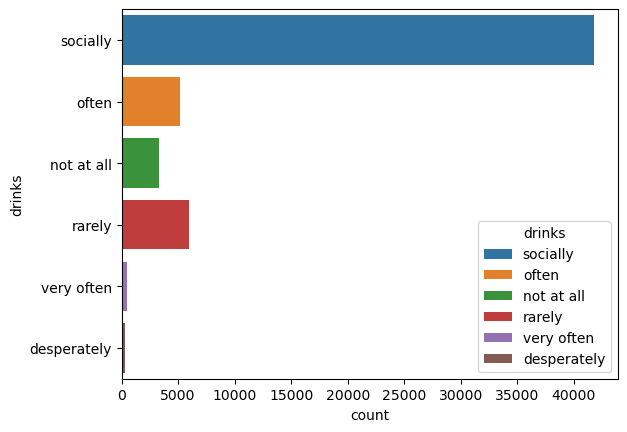

In [7]:
sns.countplot(data=df, y="drinks", hue="drinks")

# Problem to Solve
Out of almost 60,000 rows, only 19,921 have values for "Pets". If we could predict whether a user likes or dislikes dogs or cats, it could help determine compatibility with other users.

In [8]:
isna_sums = []

print("Total", len(df))

for col in df.columns:
    isna_sum = df[col].isna().sum()
    isna_sums.append([col, isna_sum])

isna_sums_sorted = sorted(isna_sums, key=lambda x: x[1], reverse=True)

for item in isna_sums_sorted:
    print(item[0], item[1])

Total 59946
offspring 35561
diet 24395
religion 20226
pets 19921
essay8 19225
drugs 14080
essay6 13771
essay9 12603
essay7 12451
essay3 11476
sign 11056
essay5 10850
essay4 10537
essay2 9638
job 8198
essay1 7572
education 6628
ethnicity 5680
smokes 5512
essay0 5488
body_type 5296
drinks 2985
speaks 50
height 3
age 0
income 0
last_online 0
location 0
orientation 0
sex 0
status 0


# Converting Values

To make a model, we will need to convert values from various cells into numeric data.

## Converting Target Values

There are 15 different values for the `pets` column in the dataset, but they can be grouped. Some values say the user likes dogs or cats, some say the user has dogs or cats, some say they dislike dogs or cats, and some only give this info for either dogs or cats. We can assume that users that have dogs like dogs, and we interpret no mention of dogs to mean we do not know for that user.

As such, we can convert any value that says the user likes or has dogs to `1`, any value that says they dislike dogs to `0`, and all remaining values becoming `NaN` to be classified later.

In [9]:
df['pets'].value_counts()

pets
likes dogs and likes cats          14814
likes dogs                          7224
likes dogs and has cats             4313
has dogs                            4134
has dogs and likes cats             2333
likes dogs and dislikes cats        2029
has dogs and has cats               1474
has cats                            1406
likes cats                          1063
has dogs and dislikes cats           552
dislikes dogs and likes cats         240
dislikes dogs and dislikes cats      196
dislikes cats                        122
dislikes dogs and has cats            81
dislikes dogs                         44
Name: count, dtype: int64

In [10]:
import numpy as np

def likes_dogs(row):
    if not isinstance(row['pets'], str):
        return np.nan

    if 'dislikes dogs' in row['pets']:
        return 0
    elif 'likes dogs' in row['pets']:
        return 1
    elif 'has dogs' in row['pets']:
        return 1
    else:
        return np.nan

df['likes_dogs'] = df.apply(likes_dogs, axis=1)

In [11]:
df['likes_dogs'].value_counts()

likes_dogs
1.0    36873
0.0      561
Name: count, dtype: int64

## Dropping Some Columns

Some columns are not very helpful for this binary classification, so we will drop them.

### essay

An analysis of the text in each essay cell could be useful, but is outside the scope of this study. As such, we will drop all essay columns.

In [12]:
columns_to_drop = list(df.filter(regex='essay').columns)

df = df.drop(columns_to_drop, axis=1)

### drinks

Most values for drinks can fit along a linear scale, but "socially" could fit anywhere inside the extremes, and it represents most of the responses to the question. We could combine all options besides "not at all" and do a binary conversion between "drinks any" and "not at all", but only 5.7% of the answers are "not at all", so that will not be very helpful. As such, we will drop this column.

### last_online
`last_online` just tells us about when we took a snapshot of this data, so it is not helpful either.

### status

Looking at the possible values of status, I am unsure what the differences are, and more than 93% of the answers are "single", we will drop this column.

In [13]:
df = df.drop(['drinks', 'last_online', 'status'], axis=1)

## Converting Feature Values

Many of the columns in the dataset have different string values that need to be converted to integers for our model to work.

### diet

The 'diet' column represents two variables: type (vegan, kosher, etc.) and strictness (strictly, mostly). It could more helpful to separate these two variables into separate columns, so I will do so.

In [14]:
df['diet'].value_counts()

diet
mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly halal            18
strictly kosher           18
halal                     11
kosher                    11
Name: count, dtype: int64

In [15]:
def restriction(row):
    if not isinstance(row['diet'], str):
        return np.nan
    
    if 'anything' in row['diet']:
        return 'anything'
    elif 'vegetarian' in row['diet']:
        return 'vegetarian'
    elif 'vegan' in row['diet']:
        return 'vegan'
    elif 'kosher' in row['diet']:
        return 'kosher'
    elif 'halal' in row['diet']:
        return 'halal'
    elif 'other' in row['diet']:
        return 'other'
    else:
        return np.nan

df['diet_type'] = df.apply(restriction, axis=1)

In [16]:
df['diet_type'].value_counts()

diet_type
anything      27881
vegetarian     4986
other          1790
vegan           702
kosher          115
halal            77
Name: count, dtype: int64

The diet type will need to be handled by one-hot encoding (covered later), but the strictness can fit along a numeric scale, so we will convert the cell to such a scale.

In [17]:
def strictness(row):
    if not isinstance(row['diet'], str):
        return np.nan

    if 'strictly' in row['diet']:
        return 2
    elif 'mostly' in row['diet']:
        return 1
    else:
        return 0

df['diet_strictness'] = df.apply(strictness, axis=1)

In [18]:
df['diet_strictness'].value_counts()

diet_strictness
1.0    21508
0.0     7339
2.0     6704
Name: count, dtype: int64

### drugs

The drugs column only has three values: 'never', 'sometimes', and 'often', which we can easily fit along a numeric scale.

In [19]:
def drugs(row):
    if not isinstance(row['drugs'], str):
        return np.nan

    if 'never' == row['drugs']:
        return 0
    elif 'sometimes' == row['drugs']:
        return 1
    elif 'often' == row['drugs']:
        return 2

df['drugs'] = df.apply(drugs, axis=1)

### education

There are a lot of different values for education, several of which can overlap. To effectively differentiate, we will group the users into the following groups: 'did not complete high school', 'did not complete college (assumed to complete high school)', 'no degree beyond college (undergraduate)', 'degree beyond undergraduate'.

We will represent these on a scale from 0 ("did not complete high school") to 3 ("degree beyond undergraduate")

A note on "space camp": it is outside of the path of traditional education, so anyone who gave that answer will be excluded from this study.

In [20]:
primary = [
    'dropped out of high school',
    'working on high school'
]
secondary = [
    'working on college/university',
    'graduated from two-year college',
    'graduated from high school',
    'working on two-year college',
    'dropped out of college/university',
    'two-year college',
    'dropped out of two-year college',
    'high school'
]
undergrad = [
    'graduated from college/university',
    'working on masters program',
    'college/university',
    'working on ph.d program',
    'working on law school',
    'working on med school',
    'dropped out of masters program',
    'dropped out of ph.d program',
    'dropped out of law school',
    'dropped out of med school',
]
advanced = [
    'graduated from masters program',
    'graduated from ph.d program',
    'graduated from law school',
    'graduated from med school',
    'masters program',
    'ph.d program',
    'law school',
    'med school'
]

def education(row):
    if not isinstance(row['education'], (str, int, float)):
        return np.nan

    if row['education'] in primary:
        return 0
    elif row['education'] in secondary:
        return 1
    elif row['education'] in undergrad:
        return 2
    elif row['education'] in advanced:
        return 3
    else:
        return np.nan

df['education'] = df.apply(education, axis=1)

### ethnicity

To align ethnicity with our classification model, we will change the column to either say a single ethnicity or "two or more". This can be easily filtered by checking whether the original cell has a comma (,) in it.

In [21]:
def ethnicity(row):
    if not isinstance(row['ethnicity'], str):
        return np.nan

    if ',' in row['ethnicity']:
        return "two or more"
    else:
        return row['ethnicity']

df['ethnicity'] = df.apply(ethnicity, axis=1)

### income

Income values are already numbers, which is good, but many of them are "-1". This could mean either less than $20,000, since that is the next lowest value, or it could mean it was not provided. Either way, we will say that any income listed as "-1" is actually "0" for our model to work.

In [22]:
def income(row):
    if not isinstance(row['income'], (int, float)):
        return np.nan

    if row['income'] < 0:
        return 0
    else:
        return row['income']

df['income'] = df.apply(income, axis=1)

### location
More than 99% of the rows are in california, so we will actually remove all other rows and focus this study on people in California.

In [23]:
df = df[df['location'].str.find('california') >= 0]

### offspring

For offspring, first we can clean up the use of the word "doesn't", which is listed as `doesn&rsquo;t`.

In [24]:
def fix_does_not_in_offspring(row):
    if not isinstance(row['offspring'], str):
        return row['offspring']

    if row['offspring'].find("doesn&rsquo;t") == -1:
        return row['offspring']

    return row['offspring'].replace("doesn&rsquo;t", "does not")

df['offspring'] = df.apply(fix_does_not_in_offspring, axis=1)

The offspring column contains multiple pieces of information. It says whether the user has 0, 1, or more than 1 kid; it says for current parents whether they want, might want, or do not want more kids; and it says for non-parents whether they want, might want, or do not want any kids.

For this analysis, we will combine all forms of new procreation into a variable which says whether the user wants to, might want to, or does not want to procreate.

In [25]:
yes_procreation_values = [
    'does not have kids, but wants them',
    'wants kids',
    'has a kid, and wants more',
    'has kids, and wants more'
]
maybe_procreation_values = [
    'does not have kids, but might want them',
    'has a kid, and might want more',
    'might want kids',
    'has kids, and might want more'
]
no_procreation_values = [
    'does not want kids',
    'does not have kids, and does not want any',
    'has kids, but does not want more',
    'has a kid, but does not want more',
]

def procreation(row):
    if not isinstance(row['offspring'], str):
        return row['offspring']

    if any(value == row['offspring'] for value in yes_procreation_values):
        return 'yes'
    elif any(value == row['offspring'] for value in maybe_procreation_values):
        return 'maybe'
    elif any(value == row['offspring'] for value in no_procreation_values):
        return 'no'
    else:
        return np.nan

df['procreation'] = df.apply(procreation, axis=1)

print(df['procreation'].value_counts())

procreation
no       4765
maybe    4398
yes      3873
Name: count, dtype: int64


We can then convert procreation to a numeric scale, from 0 to 2.

In [26]:
def procreation_int(row):
    if not isinstance(row['procreation'], str):
        return np.nan

    if row['procreation'] == 'no':
        return 0
    elif row['procreation'] == 'maybe':
        return 1
    elif row['procreation'] == 'yes':
        return 2

df['procreation_int'] = df.apply(procreation_int, axis=1)

We can also create a variable for how many kids a user has. We will assume that for the values `wants kids` and `might want kids` that the user does not have any kids currently. Further, since we only know if the user has 0, 1, or 2 or more kids, we will represent all numbers of kids > 2 as 2.

In [27]:
zero_kids_values = [
    'does not have kids',
    'does not have kids, but might want them',
    'does not have kids, but wants them',
    'does not want kids',
    'does not have kids, and does not want any',
    'wants kids',
    'might want kids'
]

one_kid_values = [
    'has a kid',
    'has a kid, but does not want more',
    'has a kid, and might want more',
    'has a kid, and wants more'
]

two_kids_values = [
    'has kids',
    'has kids, but does not want more',
    'has kids, and might want more',
    'has kids, and wants more'
]

def num_kids(row):
    if not isinstance(row['offspring'], str):
        return np.nan

    if any(value == row['offspring'] for value in zero_kids_values):
        return 0
    elif any(value == row['offspring'] for value in one_kid_values):
        return 1
    elif any(value == row['offspring'] for value in two_kids_values):
        return 2

df['num_kids'] = df.apply(num_kids, axis=1)

### religion

The religion column also has two pieces of information in it, the religious identity itself and how seriously the user takes it. We can split the column into two columns of that information.

Since we do not know whether all Catholics chose "catholicism" or if some chose "christianity", we will be combining "catholicism" and "christianity" into "christianity".

In [28]:
def religion_classification(row):
    if not isinstance(row['religion'], str):
        return np.nan

    if 'agnosticism' in row['religion']:
        return 'agnosticism'
    elif 'catholicism' in row['religion']:
        return 'christianity'
    elif 'atheism' in row['religion']:
        return 'atheism'
    elif 'christianity' in row['religion']:
        return 'christianity'
    elif 'judaism' in row['religion']:
        return 'judaism'
    elif 'buddhism' in row['religion']:
        return 'buddhism'
    elif 'hinduism' in row['religion']:
        return 'hinduism'
    elif 'islam' in row['religion']:
        return 'islam'
    elif 'other' in row['religion']:
        return 'other'
    else:
        return np.nan

df['religion_classification'] = df.apply(religion_classification, axis=1)

In [29]:
def religion_seriousness(row):
    if not isinstance(row['religion'], str):
        return np.nan

    if 'very serious about it' in row['religion']:
        return 3
    elif 'somewhat serious about it' in row['religion']:
        return 2
    elif 'not too serious about it' in row['religion']:
        return 1
    elif 'laughing about it' in row['religion']:
        return 0
    else:
        return np.nan

df['religion_seriousness'] = df.apply(religion_seriousness, axis=1)

### sex

Sex has only two values, so we can assign 0 and 1. In this case, 'm' will be 0 and 'f' will be 1

In [30]:
def sex_bin(row):
    if row['sex'] == 'm':
        return 0
    elif row['sex'] == 'f':
        return 1
    else:
        return np.nan

df['sex_bin'] = df.apply(sex_bin, axis=1)

### sign

`sign` also has two pieces of information, a user's zodiac sign and how much it matters to them. We can create two columns for this information.

The first column will be a user's zodiac sign, which will be one-hot encoded later.

In [31]:
def sign_itself(row):
    if not isinstance(row['sign'], str):
        return np.nan

    signs = ['aquarius', 'aries', 'cancer', 'capricorn', 'gemini', 'leo', 'libra', 'pisces', 'sagittarius', 'scorpio', 'taurus', 'virgo']

    for sign in signs:
        if sign in row['sign']:
            return sign
    return np.nan

df['sign_itself'] = df.apply(sign_itself, axis=1)

The second column will be how much a user's zodiac sign matters to them. This will be on a scale of 0 to 2, given that there are 3 possible answers.

In [32]:
def sign_importance(row):
    if not isinstance(row['sign'], str):
        return np.nan

    if 'but it doesn&rsquo;t matter' in row['sign']:
        return 0
    elif 'and it&rsquo;s fun to think about' in row['sign']:
        return 1
    elif 'and it matters a lot' in row['sign']:
        return 2
    else:
        return np.nan

df['sign_importance'] = df.apply(sign_importance, axis=1)

### smokes

Smokes has 5 possible values. since most of the values are "no", we can combine all variations of "yes" into "yes" and treat this as a binary classification.

In [33]:
def smokes(row):
    if not isinstance (row['smokes'], str):
        return np.nan

    if row['smokes'] == 'no':
        return 0
    elif row['smokes'] in ['sometimes', 'when drinking', 'yes', 'trying to quit']:
        return 1
    else:
        return np.nan

df['smokes_bin'] = df.apply(smokes, axis=1)

### speaks

`speaks` is a complicated one for our dataset since many people list speaking more than one language, and some list several languages along a spectrum from poorly to fluently.

For this exercise, we will limit our approach to whether the user fluently speaks English. It is assumed that if the user only selected "English" and did not qualify it, they are fluent in English.

In [34]:
def speaks_english_fluently(row):
    if not isinstance(row['speaks'], str):
        return np.nan

    return int('english (fluently)' in row['speaks'] or 'english' == row['speaks'])

df['speaks_english_fluently'] = df.apply(speaks_english_fluently, axis=1)

## One-Hot Encoding

Multiple columns in the original dataset can be made usable simply by one-hot encoding their possible values.

In [35]:
df = pd.get_dummies(
    df, 
    columns=['body_type', 'diet_type', 'job', 'orientation', 'ethnicity', 'education', 'religion_classification', 'sign_itself'], 
    dtype=int)

## Dropping Re-Encoded Columns

Now that we have encoded everything the way we want it, we can drop the columns that were re-encoded another way.

In [36]:
df = df.drop(['diet', 'location', 'offspring', 'procreation', 'religion', 'sex', 'sign', 'smokes', 'speaks', 'pets'], axis=1)

## Dropping High `NaN` Columns

Some columns have a lot of `NaN` values, and since we cannot use rows with those values in our model, we will drop those columns so we can use the rest of the data in those rows.

In [37]:
for col in df.columns:
    col_isna_sum = df[col].isna().sum()
    if col_isna_sum > 0:
        print(col, ": ", col_isna_sum)

drugs :  14057
height :  2
likes_dogs :  22476
diet_strictness :  24360
procreation_int :  46819
num_kids :  35511
religion_seriousness :  31956
sign_importance :  23142
smokes_bin :  5505
speaks_english_fluently :  50


We will keep the "likes_dogs" column since that is what we are investigating. Since the "height" and "speaks_english_fluently" columns have less than 100 `NaN` values each, we will keep those columns as well.

In [38]:
df = df.drop(['drugs', 'diet_strictness', 'procreation_int', 'num_kids', 'religion_seriousness', 'sign_importance', 'smokes_bin'], axis=1)

## Dropping `NaN` Rows

Some rows will have `NaN` in one or more cells. All of those rows need to be removed to generate the model.

In [39]:
df = df.dropna()

# Building a Model

Now that we have categorized users we can into those that like dogs and those that do not, we can build our model to predict whether a user has a dog based on other factors.

To predict, based on many factors, whether a given user likes dogs or not, we will use a Logistic Regression model.

In [40]:
df['likes_dogs'].value_counts()

likes_dogs
1.0    36802
0.0      560
Name: count, dtype: int64

In [41]:
## Separate out X and y
y = df['likes_dogs']
X = df[df.columns[df.columns!='likes_dogs']]

In [42]:
# Transform X
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [43]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

In [44]:
# Create and fit the logistic regression model here:
from sklearn.linear_model import LogisticRegression
cc_lr = LogisticRegression()
cc_lr.fit(X_train,y_train)

LogisticRegression()

# Evaluating the Model

Now that we have generated a model, let us look at how good it is using some of sklearn's built-in evaluation functions

## Confusion Matrix

In [45]:
from sklearn.metrics import confusion_matrix

y_pred = cc_lr.predict(X_test)

print(len(y_pred))
print(confusion_matrix(y_test, y_pred))

7473
[[   3   97]
 [   0 7373]]


Based on this confusion matrix, only 97 out of 7473 values were incorrect, and all were false positives.

## Accuracy, Precision, Recall, and F1 Score

In [46]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print("Accuracy: ", accuracy_score(y_test, y_pred))

print("Precision: ", precision_score(y_test, y_pred))

print("Recall: ", recall_score(y_test, y_pred))

print("F1 Score: ", f1_score(y_test, y_pred))

Accuracy:  0.987019938445069
Precision:  0.9870147255689424
Recall:  1.0
F1 Score:  0.993464932965034


This model looks pretty good! Accuracy, Precision, Recall, and the F1 Score are all above 98%. We even have a perfect recall, but given the low number of users we know that do not like dogs, the model's recall may not have been tested thoroughly enough.

# Conclusion

I learned a lot about data processing from going through this dataset. OKCupid really likes to combine multiple pieces of information together into a single column. Religious identity and religiosity do make sense to go together, but they can have different effects on user prediction.

Multiple columns also had multiple values that did fit along a nice scale, but they would sometimes be mixed with values that did not. For example, the "smokes" column, representing whether the user smokes, had the values "no", "sometimes", and "yes", but it also had the value "trying to quit", which could align with "sometimes" or "yes".

Given the sheer number of variables used to make this model, it makes sense that the accuracy, precision, recall, and F1 scores were so high (> 98% each), but with only 1.5% of the data being negative, these scores cannot be trusted too much.

To better ascertain whether someone likes dogs or not, we need more data on users who do not like dogs.